In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/air-ticket/train_data.csv
/kaggle/input/air-ticket/test_data.csv
/kaggle/input/air-ticket/sample_solution.csv


**Assalamu alaykum, our task is to create model that predicts price of air ticket, let's jump in to the problem**

First we have import all libraries those we use to solve this problem.

In [2]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import StratifiedShuffleSplit
import pandas as pd
import numpy as  np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

**Then we download our train data.**

In [3]:
df = pd.read_csv('/kaggle/input/air-ticket/train_data.csv', index_col=0)

df.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
id,,,,,,,,,,,
1,Vistara,UK-810,Bangalore,Early_Morning,one,Night,Mumbai,Economy,14.25,21,7212
2,SpiceJet,SG-5094,Hyderabad,Evening,zero,Night,Kolkata,Economy,1.75,7,5292
3,Vistara,UK-846,Bangalore,Morning,one,Evening,Delhi,Business,9.58,5,60553
4,Vistara,UK-706,Kolkata,Morning,one,Evening,Hyderabad,Economy,6.75,28,5760
5,Indigo,6E-5394,Chennai,Early_Morning,zero,Morning,Mumbai,Economy,2.00,4,10712


**We do some analysis on this data.**

In [4]:
df.shape

(20000, 11)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 1 to 20000
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   airline           20000 non-null  object 
 1   flight            20000 non-null  object 
 2   source_city       20000 non-null  object 
 3   departure_time    20000 non-null  object 
 4   stops             20000 non-null  object 
 5   arrival_time      20000 non-null  object 
 6   destination_city  20000 non-null  object 
 7   class             20000 non-null  object 
 8   duration          20000 non-null  float64
 9   days_left         20000 non-null  int64  
 10  price             20000 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.8+ MB


**You can see there is not any null values in or data, which means very good.**

**Now we draw some beautifull diagramms**

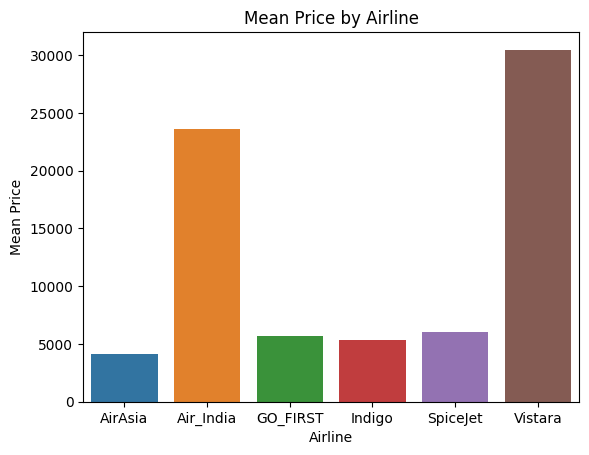

In [6]:
df_by_airline = df.groupby(by='airline')['price'].mean()

if isinstance(df_by_airline, pd.DataFrame):
    sns.barplot(data=df_by_airline, x=df_by_airline.index, y='price')
else:
    sns.barplot(data=df_by_airline.reset_index(), x='airline', y='price')

plt.xlabel('Airline')
plt.ylabel('Mean Price')
plt.title('Mean Price by Airline')
plt.show()

**You can see here mean price of tickets from Air India and Vistara are more more expensive then others.**

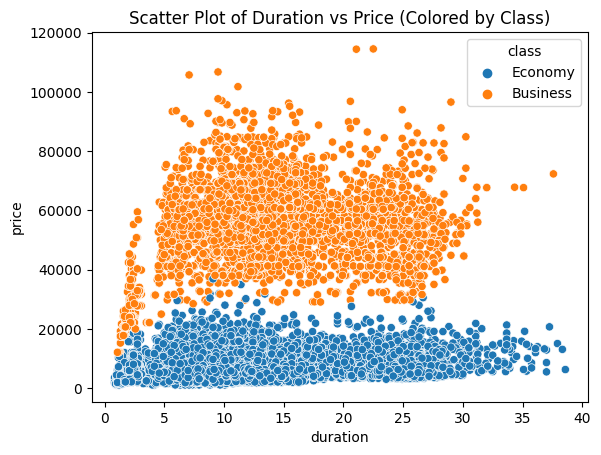

In [7]:
sns.scatterplot(data=df, x='duration', y='price', hue='class')
plt.title('Scatter Plot of Duration vs Price (Colored by Class)')
plt.show()

**You can see here correlation between duration of flight and price, dots with orange color are business class tickets, and with blue colors are economy class.**

**Here is correlation between price and other numeric columns.**

In [8]:
numeric_columns = df.select_dtypes(include=[np.number])
correlation_result = numeric_columns.corr()['price']
print(correlation_result)

duration     0.213158
days_left   -0.102545
price        1.000000
Name: price, dtype: float64


**And now it is time to create new features.**

**Every flight has its own flight code, let's say 30 people is flying in one airplane, these 30 people have the same flight code in their tickets. Correlation between flight code and price is if number of tickets that belong to one flight is more price of tickets will be chipper, otherwise if tickets are less price will be expensive due to heigher demand.**

**We create a feature named 'number_of_tickets' which refers number of tickets that belong to same flight.**

In [9]:
def number_of_tickets(code):
    return len(df[df['flight'] == code])

df['number_of_tickets'] = df['flight'].map(lambda x: number_of_tickets(x))

In [10]:
numeric_columns = df.select_dtypes(include=[np.number])
correlation_result = numeric_columns.corr()['price']
print(correlation_result)

duration             0.213158
days_left           -0.102545
price                1.000000
number_of_tickets    0.375029
Name: price, dtype: float64


**Correlation between new feature that we have create and price is heigher than others, which is very very useful for accuracy of our model.**

**I found that to two airlines, Vistara and Air India have both business and economy class, others have only economy class, so we create a feature that inform wheather airline has business class.**

In [11]:
have_business_dict = {
    'Vistara': 'yes',
    'SpiceJet': 'no',
    'Indigo': 'no',
    'Air_India': 'yes',
    'GO_FIRST': 'no',
    'AirAsia': 'no'
}

df['have_business'] = df['airline'].map(have_business_dict)

**Some flights have no division, some others have one, if airplace stops one time flight have 2 division, if stops 2 times it has 3 division.**

In [12]:
division_of_flight = {
    'zero': 1,
    'one': 2,
    'two_or_more': 3
}

df['division_of_flight'] = df['stops'].map(division_of_flight)

**I think these features are enough to do ML, I created many other features, but instead of improves accuracy of model they worseden accuracy.**

**It is time to split the dataframe into train and test parts, we use Stratified Shuffle Split to do this.**

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

df['price_group'] = pd.cut(df['price'], bins=[0, 5000, 10000, 20000, 50000, 200000], labels=['0-5k', '5k-10k', '10k-20k', '20k-50k', '50k-200k'], include_lowest=True)

# Assuming 'df' is your DataFrame and 'price_group' is the target variable
stratified_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

for train_index, test_index in stratified_splitter.split(df, df['price_group']):
    train_set = df.iloc[train_index]
    test_set = df.iloc[test_index]

**We split both train and test set into X and y parts.**

In [14]:
X_train = train_set.drop(['price'], axis=1)
X_test  = test_set.drop(['price'], axis=1)

y_train = train_set['price'].copy()
y_test  = test_set['price'].copy()

**Now we prepare both train and test data to Machine learning with multiple steps, like One Hot Encoding, Standard Scaling.**

In [15]:
cat_columns = ['airline', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class', 'have_business']
num_columns = ['duration', 'days_left', 'division_of_flight', 'number_of_tickets']

train_num = X_train[num_columns]

test_num = X_test[num_columns]

train_cat = X_train[cat_columns]

test_cat = X_test[cat_columns]

In [16]:
one_hot_encoder = OneHotEncoder()

cat_one_hot = one_hot_encoder.fit_transform(train_cat)

test_cat_one_hot = one_hot_encoder.fit_transform(test_cat)

In [17]:
standard_scaler = StandardScaler()

num_standard_scaler = standard_scaler.fit_transform(train_num)

test_num_standard_scaler = standard_scaler.fit_transform(test_num)

In [18]:
cat_one_hot_dense = cat_one_hot.toarray()

final_train = np.hstack((cat_one_hot_dense, num_standard_scaler))

final_X_train = pd.DataFrame(final_train, columns=np.concatenate((one_hot_encoder.get_feature_names_out(), train_num.columns)), index=X_train.index)

In [19]:
cat_one_hot_dense = test_cat_one_hot.toarray()

final_test = np.hstack((cat_one_hot_dense, test_num_standard_scaler))

final_X_test = pd.DataFrame(final_test, columns=np.concatenate((one_hot_encoder.get_feature_names_out(), test_num.columns)), index=X_test.index)

**Finally we do Machine Learning, I chose Random Forest Regression and XGB Regressor to create model.**

In [20]:
# Initialize base models
base_models = [
    ('rf', RandomForestRegressor(
        n_estimators=300,
        criterion='squared_error',
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        #max_features='auto',  # You can also use 'sqrt' or an integer value
        bootstrap=True,
        random_state=42,
        n_jobs=-10
    )),
    ('xgb', XGBRegressor())
]

# Initialize stacking regressor with a meta-model
stacking_model = StackingRegressor(estimators=base_models, final_estimator=Lasso(alpha=0.1))

# Train the stacking model
stacking_model.fit(final_X_train, y_train)

# Make predictions on the test set
y_pred = stacking_model.predict(final_X_test)

# Evaluate the model
np.sqrt(mean_squared_error(y_test, y_pred))

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.027e+11, tolerance: 9.328e+08
  model = cd_fast.enet_coordinate_descent(


3258.242643232634

😎😎😎😎


**RMSE of our model is 3258, the treshold is 3280.01117.
**

**Now we have to predict test data to sumbission.**

In [21]:
test_df = pd.read_csv('/kaggle/input/air-ticket/test_data.csv')
df.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price,number_of_tickets,have_business,division_of_flight,price_group
id,,,,,,,,,,,,,,,
1,Vistara,UK-810,Bangalore,Early_Morning,one,Night,Mumbai,Economy,14.25,21,7212,126,yes,2,5k-10k
2,SpiceJet,SG-5094,Hyderabad,Evening,zero,Night,Kolkata,Economy,1.75,7,5292,2,no,1,5k-10k
3,Vistara,UK-846,Bangalore,Morning,one,Evening,Delhi,Business,9.58,5,60553,94,yes,2,50k-200k
4,Vistara,UK-706,Kolkata,Morning,one,Evening,Hyderabad,Economy,6.75,28,5760,208,yes,2,5k-10k
5,Indigo,6E-5394,Chennai,Early_Morning,zero,Morning,Mumbai,Economy,2.00,4,10712,8,no,1,10k-20k


In [22]:
test_df['number_of_tickets'] = test_df['flight'].map(lambda x: number_of_tickets(x))

In [23]:
have_business_dict = {
    'Vistara': 'yes',
    'SpiceJet': 'no',
    'Indigo': 'no',
    'Air_India': 'yes',
    'GO_FIRST': 'no',
    'AirAsia': 'no'
}

test_df['have_business'] = test_df['airline'].map(have_business_dict)

In [24]:
division_of_flight = {
    'zero': 1,
    'one': 2,
    'two_or_more': 3
}

test_df['division_of_flight'] = test_df['stops'].map(division_of_flight)

In [25]:
cat_columns = ['airline', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class', 'have_business']
num_columns = ['duration', 'days_left', 'division_of_flight', 'number_of_tickets']

test_num = test_df[num_columns]

test_cat = test_df[cat_columns]

In [26]:
one_hot_encoder = OneHotEncoder()

test_cat_one_hot = one_hot_encoder.fit_transform(test_cat)

In [27]:
standard_scaler = StandardScaler()

test_num_standard_scaler = standard_scaler.fit_transform(test_num)

In [28]:
cat_one_hot_dense = test_cat_one_hot.toarray()

final_test = np.hstack((cat_one_hot_dense, test_num_standard_scaler))

final_test = pd.DataFrame(final_test, columns=np.concatenate((one_hot_encoder.get_feature_names_out(), test_num.columns)), index=test_df.index)

In [29]:
test_prediction = stacking_model.predict(final_test)

In [30]:
submission_df = pd.DataFrame({
    'id': test_df.index,
    'price': test_prediction
})

submission_df.head()

,id,price
0,0,52985.031757
1,1,56627.490017
2,2,23077.919861
3,3,2990.478480
4,4,5778.864193


In [31]:
submission_df.to_csv('submission.csv', index=False)